In [89]:
import os,random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import ntpath


In [16]:
import keras,os
import tensorflow as tf
from keras.models import Sequential # Gets our neural network as sequential network
from keras.layers import Conv2D # Images are basically 2D
from keras.layers import MaxPool2D # Average Pooling, Sum Pooling and Max Pooling is there. we use Max pooling
from keras.layers import Flatten # It is process of converting all 2D array to continious linear vector
from keras.layers import Dense # Full connection of this neural network is performed using dense
from keras.preprocessing.image import ImageDataGenerator # It helps rescale, flip, rotate etc
import numpy as np

In [3]:
# Import VGG16 Pretrained model
# Instantiate convolutional base
from keras.applications import VGG16
from keras import layers
from keras import optimizers

In [26]:

base_dir = r'D:\compvision\hindichar'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'test')
train_bg_dir = os.path.join(train_dir, 'background')

train_hi_dir = os.path.join(train_dir, 'hi')
test_hi_dir = os.path.join(test_dir, 'hi')
test_background_dir = os.path.join(test_dir, 'background')

In [27]:
file_count = sum(len(files) for _, _, files in os.walk(train_bg_dir))
print(file_count)

4450


In [28]:
file_count = sum(len(files) for _, _, files in os.walk(train_hi_dir))
print(file_count)

1425


In [29]:
file_count = sum(len(files) for _, _, files in os.walk(test_dir))
print(file_count)

98


In [30]:
train_size, test_size = 5875,98

In [31]:
img_width, img_height=64,64

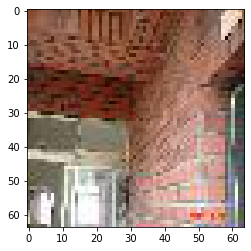

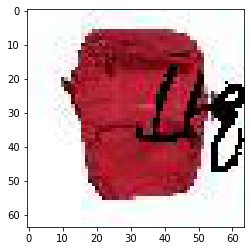

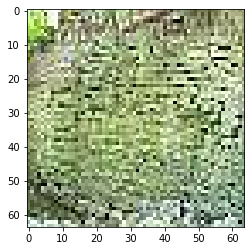

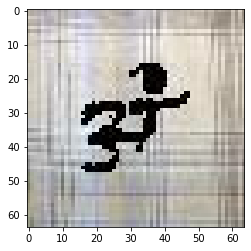

In [32]:
# Show pictures

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_bg_dir)
    show_pictures(train_hi_dir)

In [34]:
vgg16covbase= VGG16(weights='imagenet', # pretraining on imagenet
                  include_top=False, # whether to include the 3 fully-connected layers at the top of the network.
                  input_shape=(64, 64, 3))  # 3 = number of channels in RGB pictures
# The entire layers are present inside this.The feature extractor is inbuilt

In [35]:
vgg16covbase.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [37]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 2, 2, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(64,64),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16covbase.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size

test_features, test_labels = extract_features(test_dir, test_size)

Found 5875 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [42]:
from keras import models

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(2,2,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(2*2*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 524,801
Trainable params: 524,801
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [44]:
history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=batch_size, 
                    validation_data=(test_features, test_labels))

Epoch 1/100
184/184 [==============================] - 1s 4ms/step - loss: 0.3804 - acc: 0.8329 - val_loss: 0.4572 - val_acc: 0.7755
Epoch 2/100
184/184 [==============================] - 1s 3ms/step - loss: 0.2798 - acc: 0.8863 - val_loss: 0.4405 - val_acc: 0.8265
Epoch 3/100
184/184 [==============================] - 1s 3ms/step - loss: 0.2402 - acc: 0.9055 - val_loss: 0.5325 - val_acc: 0.7653
Epoch 4/100
184/184 [==============================] - 1s 3ms/step - loss: 0.2068 - acc: 0.9181 - val_loss: 0.4083 - val_acc: 0.8571
Epoch 5/100
184/184 [==============================] - 1s 3ms/step - loss: 0.1777 - acc: 0.9340 - val_loss: 0.4261 - val_acc: 0.8571
Epoch 6/100
184/184 [==============================] - 1s 3ms/step - loss: 0.1558 - acc: 0.9435 - val_loss: 0.4319 - val_acc: 0.8673
Epoch 7/100
184/184 [==============================] - 1s 3ms/step - loss: 0.1381 - acc: 0.9476 - val_loss: 0.3944 - val_acc: 0.8571
Epoch 8/100
184/184 [==============================] - 1s 3ms/step - 

Epoch 62/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0258 - acc: 0.9910 - val_loss: 0.7350 - val_acc: 0.9082
Epoch 63/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0165 - acc: 0.9940 - val_loss: 0.7903 - val_acc: 0.8980
Epoch 64/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0165 - acc: 0.9932 - val_loss: 0.7554 - val_acc: 0.8980
Epoch 65/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0160 - acc: 0.9942 - val_loss: 0.7415 - val_acc: 0.9184
Epoch 66/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0172 - acc: 0.9935 - val_loss: 0.8306 - val_acc: 0.9082
Epoch 67/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0155 - acc: 0.9946 - val_loss: 0.7600 - val_acc: 0.9082
Epoch 68/100
184/184 [==============================] - 1s 3ms/step - loss: 0.0343 - acc: 0.9871 - val_loss: 0.8396 - val_acc: 0.8980
Epoch 69/100
184/184 [==============================] - 1s 3ms

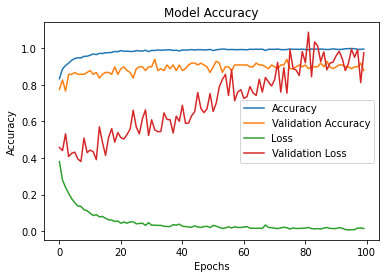

In [45]:
# Plot results
import matplotlib.pyplot as plt

plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epochs')
plt.legend(['Accuracy','Validation Accuracy','Loss', 'Validation Loss'])

In [175]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    datalist=[]
    for i in range(0,n_cases):
        path = random.choice([test_background_dir, test_hi_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = vgg16covbase.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        #plt.imshow(img_tensor)
        #plt.show()

        # Write prediction
        if prediction < 0.9:
            tup1=(ntpath.basename(img_path),'0')
            datalist.append(tup1)
            print(ntpath.basename(img_path),':0')
        else:
            tup2=(ntpath.basename(img_path),'1')
            datalist.append(tup2)
            print(ntpath.basename(img_path),':1')
    return(datalist) 

In [209]:

result=visualize_predictions(model, 98)

34.jpg :0
28.jpg :1
28.jpg :1
98.jpg :0
62.jpg :1
38.jpg :0
45.jpg :0
60.jpg :0
24.jpg :1
49.jpg :0
92.jpg :0
90.jpg :1
76.jpg :0
28.jpg :1
3.jpg :1
1.jpg :1
94.jpg :1
42.jpg :1
64.jpg :0
30.jpg :1
66.jpg :0
85.jpg :0
17.jpg :0
78.jpg :0
64.jpg :0
10.jpg :0
94.jpg :1
37.jpg :0
96.jpg :0
51.jpg :0
93.jpg :0
69.jpg :1
1.jpg :1
82.jpg :1
11.jpg :1
76.jpg :0
45.jpg :0
55.jpg :1
52.jpg :1
93.jpg :0
89.jpg :0
51.jpg :0
20.jpg :0
21.jpg :1
64.jpg :0
71.jpg :1
10.jpg :0
60.jpg :0
89.jpg :0
30.jpg :1
63.jpg :1
29.jpg :1
65.jpg :0
47.jpg :0
23.jpg :1
93.jpg :0
89.jpg :0
66.jpg :0
81.jpg :1
58.jpg :0
52.jpg :1
58.jpg :0
42.jpg :1
40.jpg :1
19.jpg :1
12.jpg :0
9.jpg :0
55.jpg :1
39.jpg :0
60.jpg :0
40.jpg :1
26.jpg :1
78.jpg :0
64.jpg :0
21.jpg :1
11.jpg :1
65.jpg :0
87.jpg :0
1.jpg :1
72.jpg :0
30.jpg :1
79.jpg :0
82.jpg :1
21.jpg :1
10.jpg :0
75.jpg :0
59.jpg :0
89.jpg :0
9.jpg :0
29.jpg :1
28.jpg :1
82.jpg :1
95.jpg :0
20.jpg :0
82.jpg :1
12.jpg :0
75.jpg :0
84.jpg :1


In [210]:
print(type(result))

<class 'list'>


In [178]:
result

[('37.jpg', '0'),
 ('75.jpg', '0'),
 ('15.jpg', '0'),
 ('91.jpg', '1'),
 ('77.jpg', '0'),
 ('6.jpg', '0'),
 ('95.jpg', '0'),
 ('57.jpg', '0'),
 ('9.jpg', '0'),
 ('55.jpg', '1')]

In [211]:
import json
import pandas as pd

In [212]:
df=pd.DataFrame(result)

In [213]:
df

,0,1
0,34.jpg,0
1,28.jpg,1
2,28.jpg,1
3,98.jpg,0
4,62.jpg,1
...,...,...
93,20.jpg,0
94,82.jpg,1
95,12.jpg,0
96,75.jpg,0


In [214]:
df2 = df.set_axis(['filename','res'], axis=1, inplace=False)


In [215]:
df2

,filename,res
0,34.jpg,0
1,28.jpg,1
2,28.jpg,1
3,98.jpg,0
4,62.jpg,1
...,...,...
93,20.jpg,0
94,82.jpg,1
95,12.jpg,0
96,75.jpg,0


In [216]:
df2.to_json('teamrock_json')